# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


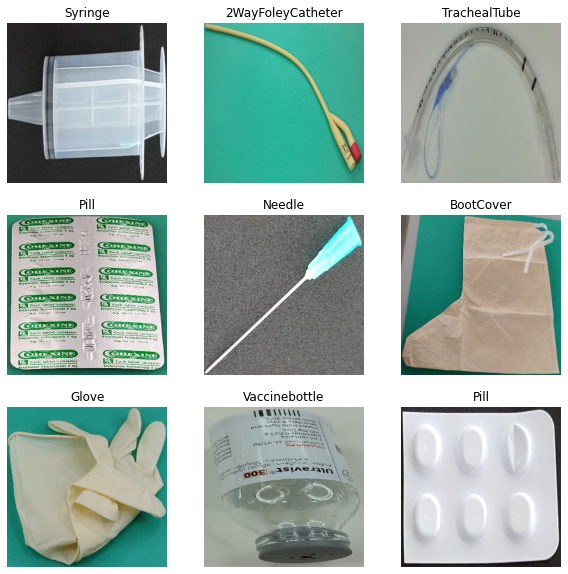

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


## Class Weight

In [21]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

In [22]:
print(len(y_train))
print(y_train)

3095
[ 2 25 33 ... 25 26  5]


In [23]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}
print(class_weight_value)

{0: 5.806754221388368, 1: 2.220229555236729, 2: 2.040210942649967, 3: 4.193766937669377, 4: 1.9355847404627893, 5: 0.5510058750222538, 6: 4.440459110473458, 7: 2.156794425087108, 8: 2.287509238728751, 9: 1.9865211810012837, 10: 4.193766937669377, 11: 3.2820784729586427, 12: 2.695993031358885, 13: 2.156794425087108, 14: 3.9730423620025674, 15: 3.59465737514518, 16: 0.39730423620025673, 17: 4.717987804878049, 18: 0.3931656504065041, 19: 0.2755029375111269, 20: 1.451688555347092, 21: 1.3243474540008557, 22: 0.3682331945270672, 23: 1.5726626016260163, 24: 1.7555303460011344, 25: 0.46029149315883405, 26: 0.11685418711772257, 27: 0.9932605905006419, 28: 2.7958446251129176, 29: 4.440459110473458, 30: 2.516260162601626, 31: 1.0065040650406505, 32: 4.193766937669377, 33: 4.193766937669377, 34: 1.6061235080435912, 35: 2.516260162601626, 36: 0.5278867473989425, 37: 3.9730423620025674, 38: 3.774390243902439, 39: 0.6739982578397212, 40: 2.4350904799370574}


# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR/'

In [26]:
EPOCHS = 2000
save_model_interval = 10
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr],class_weight=class_weight_value)

Epoch 1/2000
49/49 [==============================] - 24s 340ms/step - loss: 2.3267 - accuracy: 0.5195 - val_loss: 1.0968 - val_accuracy: 0.8189
Epoch 2/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.7637 - accuracy: 0.8659 - val_loss: 0.6341 - val_accuracy: 0.8849
Epoch 3/2000
49/49 [==============================] - 9s 182ms/step - loss: 0.4237 - accuracy: 0.9186 - val_loss: 0.4668 - val_accuracy: 0.9133
Epoch 4/2000
49/49 [==============================] - 9s 181ms/step - loss: 0.2871 - accuracy: 0.9460 - val_loss: 0.3744 - val_accuracy: 0.9353
Epoch 5/2000
49/49 [==============================] - 9s 180ms/step - loss: 0.2136 - accuracy: 0.9612 - val_loss: 0.3184 - val_accuracy: 0.9405
Epoch 6/2000
49/49 [==============================] - 9s 180ms/step - loss: 0.1667 - accuracy: 0.9703 - val_loss: 0.2825 - val_accuracy: 0.9405
Epoch 7/2000
49/49 [==============================] - 9s 180ms/step - loss: 0.1341 - accuracy: 0.9780 - val_loss: 0.2578 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

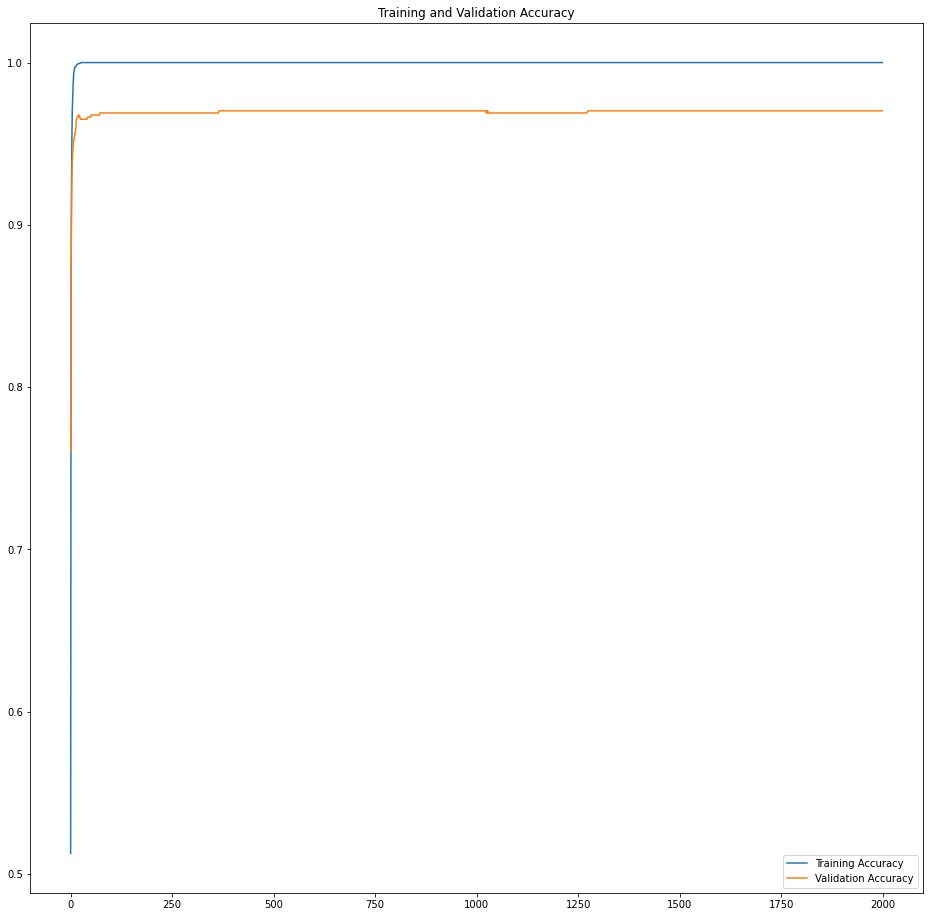

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


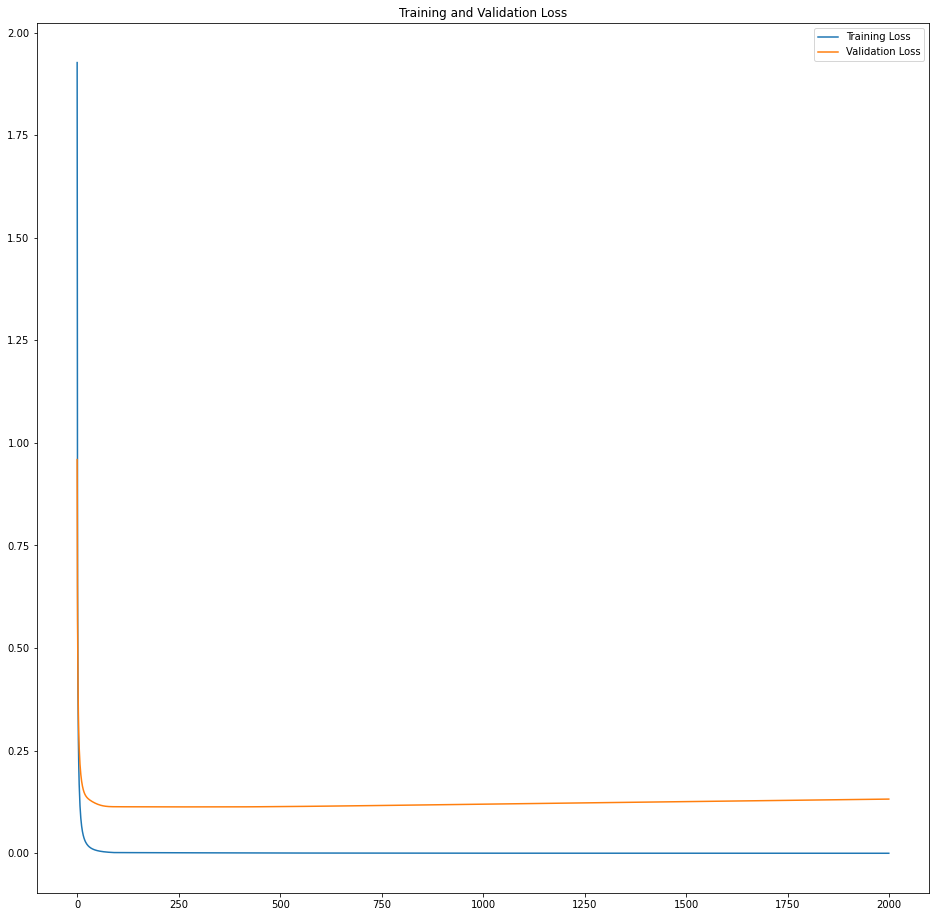

In [39]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 350ms/step - loss: 0.7002 - accuracy: 0.8523
test_indoor_ds_results:test loss, test acc: [0.7002391219139099, 0.8522853851318359]


In [41]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 458ms/step - loss: 1.8556 - accuracy: 0.7344
test_outdoor_ds_results:test loss, test acc: [1.855570912361145, 0.734394907951355]


In [42]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 201ms/step - loss: 2.0771 - accuracy: 0.6854
test_belt_ds_results:test loss, test acc: [2.07714581489563, 0.6854034662246704]


In [47]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0010-val_acc0.95.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0020-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0030-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0050-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-e

# Testing in testset

In [48]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 149ms/step - loss: 1.2229 - accuracy: 0.6514
Epoch010 
 test_indoor_acc=0.8205128312110901 
 test_outdoor_acc=0.7222930192947388 
 test_belt_acc=0.6514052748680115
35/35 [==============================] - 5s 145ms/step - loss: 1.2617 - accuracy: 0.6618
Epoch020 
 test_indoor_acc=0.8322185277938843 
 test_outdoor_acc=0.734394907951355 
 test_belt_acc=0.6618313789367676
35/35 [==============================] - 5s 143ms/step - loss: 1.3048 - accuracy: 0.6632
Epoch030 
 test_indoor_acc=0.8350055813789368 
 test_outdoor_acc=0.7388535141944885 
 test_belt_acc=0.6631913185119629
35/35 [==============================] - 5s 142ms/step - loss: 1.3390 - accuracy: 0.6646
Epoch040 
 test_indoor_acc=0.8383500576019287 
 test_outdoor_acc=0.7410827875137329 
 test_belt_acc=0.6645511984825134
35/35 [==============================] - 5s 143ms/step - loss: 1.3695 - accuracy: 0.6646
Epoch050 
 test_indoor_acc=0.8422519564628601 
 test_outdoor_acc=0.7414012551307

range(10, 2010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

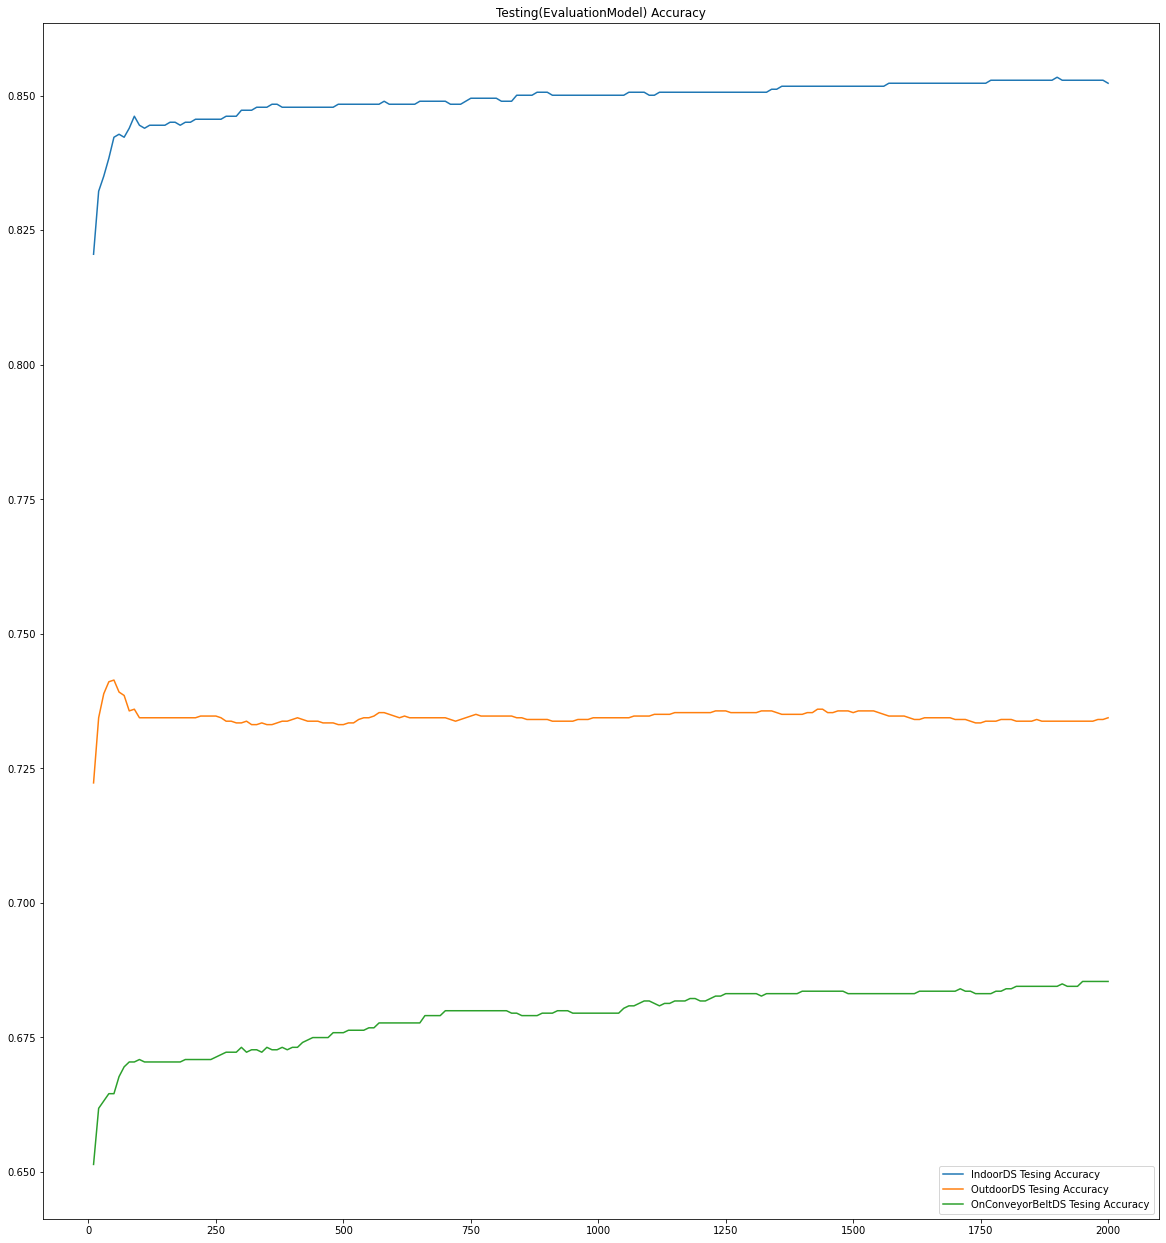

In [49]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

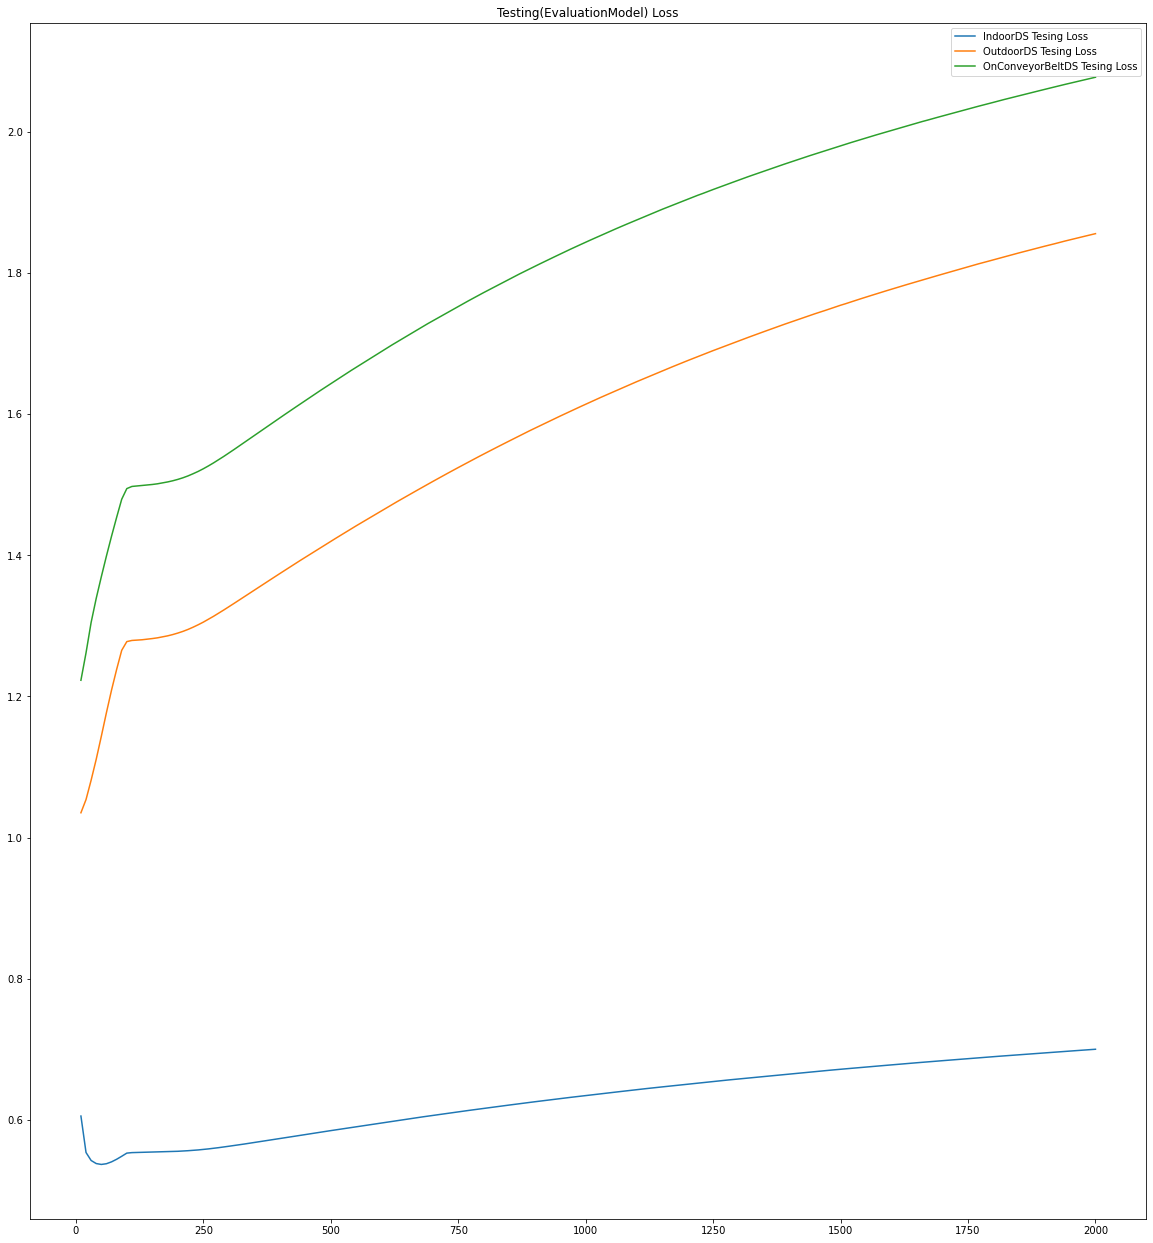

In [50]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [51]:
test_indoor_acc

[0.8205128312110901,
 0.8322185277938843,
 0.8350055813789368,
 0.8383500576019287,
 0.8422519564628601,
 0.8428093791007996,
 0.8422519564628601,
 0.8439241647720337,
 0.8461538553237915,
 0.8444815874099731,
 0.8439241647720337,
 0.8444815874099731,
 0.8444815874099731,
 0.8444815874099731,
 0.8444815874099731,
 0.8450390100479126,
 0.8450390100479126,
 0.8444815874099731,
 0.8450390100479126,
 0.8450390100479126,
 0.845596432685852,
 0.845596432685852,
 0.845596432685852,
 0.845596432685852,
 0.845596432685852,
 0.845596432685852,
 0.8461538553237915,
 0.8461538553237915,
 0.8461538553237915,
 0.8472687005996704,
 0.8472687005996704,
 0.8472687005996704,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8483834862709045,
 0.8483834862709045,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651

In [52]:
test_outdoor_acc

[0.7222930192947388,
 0.734394907951355,
 0.7388535141944885,
 0.7410827875137329,
 0.7414012551307678,
 0.7391719818115234,
 0.7385350465774536,
 0.7356687784194946,
 0.7359872460365295,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.734394907951355,
 0.7347133755683899,
 0.7347133755683899,
 0.7347133755683899,
 0.7347133755683899,
 0.734394907951355,
 0.7337579727172852,
 0.7337579727172852,
 0.7334395051002502,
 0.7334395051002502,
 0.7337579727172852,
 0.7331210374832153,
 0.7331210374832153,
 0.7334395051002502,
 0.7331210374832153,
 0.7331210374832153,
 0.7334395051002502,
 0.7337579727172852,
 0.7337579727172852,
 0.7340764403343201,
 0.734394907951355,
 0.7340764403343201,
 0.7337579727172852,
 0.7337579727172852,
 0.7337579727172852,
 0.7334395051002502,
 0.7334395051002502,
 0.7334395051002502,
 0.7331

In [53]:
test_belt_acc

[0.6514052748680115,
 0.6618313789367676,
 0.6631913185119629,
 0.6645511984825134,
 0.6645511984825134,
 0.6677243709564209,
 0.6695376038551331,
 0.6704442501068115,
 0.6704442501068115,
 0.6708975434303284,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6704442501068115,
 0.6708975434303284,
 0.6708975434303284,
 0.6708975434303284,
 0.6708975434303284,
 0.6708975434303284,
 0.6708975434303284,
 0.6713508367538452,
 0.6718041896820068,
 0.6722574830055237,
 0.6722574830055237,
 0.6722574830055237,
 0.6731640696525574,
 0.6722574830055237,
 0.6727107763290405,
 0.6727107763290405,
 0.6722574830055237,
 0.6731640696525574,
 0.6727107763290405,
 0.6727107763290405,
 0.6731640696525574,
 0.6727107763290405,
 0.6731640696525574,
 0.6731640696525574,
 0.6740707159042358,
 0.6745240092277527,
 0.6749773621559143,
 0.6749773621559143,
 0.6749773621559143,
 0.6749773621559143,
 0.6758839488

In [54]:
test_indoor_loss

[0.6055979132652283,
 0.5539761185646057,
 0.5426760315895081,
 0.5383127927780151,
 0.5370658040046692,
 0.5380706787109375,
 0.5407214760780334,
 0.5443688631057739,
 0.5486318469047546,
 0.553101658821106,
 0.5538170337677002,
 0.5540104508399963,
 0.5541662573814392,
 0.5543366074562073,
 0.5544955730438232,
 0.5546494722366333,
 0.5548897385597229,
 0.5551089644432068,
 0.5553810596466064,
 0.5556944608688354,
 0.5560741424560547,
 0.5565236806869507,
 0.5570408701896667,
 0.5576134920120239,
 0.5583276152610779,
 0.5590708255767822,
 0.5599144697189331,
 0.5608259439468384,
 0.5617638230323792,
 0.5628225207328796,
 0.5638070702552795,
 0.5648669004440308,
 0.5659341812133789,
 0.567035436630249,
 0.5681366920471191,
 0.5692442655563354,
 0.5703787207603455,
 0.5714893937110901,
 0.5726088285446167,
 0.5737313628196716,
 0.574868381023407,
 0.5759907960891724,
 0.5771005153656006,
 0.5782424211502075,
 0.579336941242218,
 0.5805000066757202,
 0.5816174149513245,
 0.58273857831954

In [55]:
test_outdoor_loss

[1.0352505445480347,
 1.0539416074752808,
 1.0813665390014648,
 1.111049771308899,
 1.143530011177063,
 1.1769834756851196,
 1.208878517150879,
 1.2381443977355957,
 1.2653504610061646,
 1.2776799201965332,
 1.2793279886245728,
 1.2797740697860718,
 1.2803075313568115,
 1.2811323404312134,
 1.2819973230361938,
 1.2830159664154053,
 1.2843904495239258,
 1.2858316898345947,
 1.2876449823379517,
 1.2897599935531616,
 1.2921419143676758,
 1.2949296236038208,
 1.2980984449386597,
 1.3015505075454712,
 1.3052451610565186,
 1.3093043565750122,
 1.3134804964065552,
 1.3178631067276,
 1.3223764896392822,
 1.3269215822219849,
 1.3316419124603271,
 1.3363335132598877,
 1.341062068939209,
 1.3457757234573364,
 1.3505067825317383,
 1.3552734851837158,
 1.3599627017974854,
 1.3646363019943237,
 1.3693852424621582,
 1.3740135431289673,
 1.378692865371704,
 1.3833798170089722,
 1.3879725933074951,
 1.3925541639328003,
 1.397082805633545,
 1.4017144441604614,
 1.4062020778656006,
 1.4107528924942017,
 

In [56]:
test_belt_loss

[1.2229410409927368,
 1.2617417573928833,
 1.30482017993927,
 1.3389554023742676,
 1.3695478439331055,
 1.39886474609375,
 1.4268885850906372,
 1.4535846710205078,
 1.4793684482574463,
 1.4944313764572144,
 1.4974725246429443,
 1.4981461763381958,
 1.4987356662750244,
 1.4995266199111938,
 1.5002691745758057,
 1.5012158155441284,
 1.502519130706787,
 1.5038548707962036,
 1.5054938793182373,
 1.5074528455734253,
 1.5097259283065796,
 1.5123980045318604,
 1.5154889822006226,
 1.5187898874282837,
 1.5225003957748413,
 1.526523232460022,
 1.5307945013046265,
 1.5352972745895386,
 1.5399428606033325,
 1.5447291135787964,
 1.5496232509613037,
 1.554582953453064,
 1.5594857931137085,
 1.564516305923462,
 1.5695061683654785,
 1.5745269060134888,
 1.5795365571975708,
 1.5845668315887451,
 1.5895215272903442,
 1.5944559574127197,
 1.5994786024093628,
 1.604455828666687,
 1.6092876195907593,
 1.6141786575317383,
 1.6189481019973755,
 1.623894453048706,
 1.6287224292755127,
 1.6335630416870117,
 1

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch2000-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5418
FP=1722
acc=0.7588235294117647
all check = 7140


In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 91.15646258503402%
2WayFoleyCatheter acc = 73.13432835820896%
3WayConnectorforFoley acc = 93.16239316239316%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 47.61904761904761%
BootCover acc = 67.46987951807229%
CottonBall acc = 79.04191616766467%
CottonSwap acc = 81.11888111888112%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 55.75221238938053%
ExtensionTube acc = 39.02439024390244%
FaceShield acc = 72.8395061728395%
FrontLoadSyringe acc = 61.94690265486725%
GauzePad acc = 61.36363636363637%
Glove acc = 75.59523809523809%
GuideWire acc = 32.142857142857146%
LiquidBottle acc = 61.832061068702295%
Mask acc = 93.24675324675324%
NGTube acc = 44.516129032258064%
NasalCannula acc = 68.14159292035397%
Needle acc = 78.92857142857143%
OxygenMask acc = 98.49624060150376%
PPESuit acc = 95.96774193548387%
PharmaceuticalProduct acc = 66.1214953271028%
Pill acc = 95.7983193277311%
PillBot

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   0, ...,   0,   1,   0],
       [  0, 134,   0, ...,   0,   0,   0],
       [  0,   0,  98, ...,   0,   3,   7],
       ...,
       [  0,   0,   0, ...,  72,   0,   1],
       [  0,   0,   0, ...,   1, 180,   0],
       [  0,   1,   0, ...,   0,   2,  78]], dtype=int64)

In [8]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.        , 91.15646259,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 73.13432836, ...,  0.        ,
         2.23880597,  5.2238806 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 60.        ,
         0.        ,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        84.50704225,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.        ,
         1.75438596, 68.42105263]])

<AxesSubplot:>

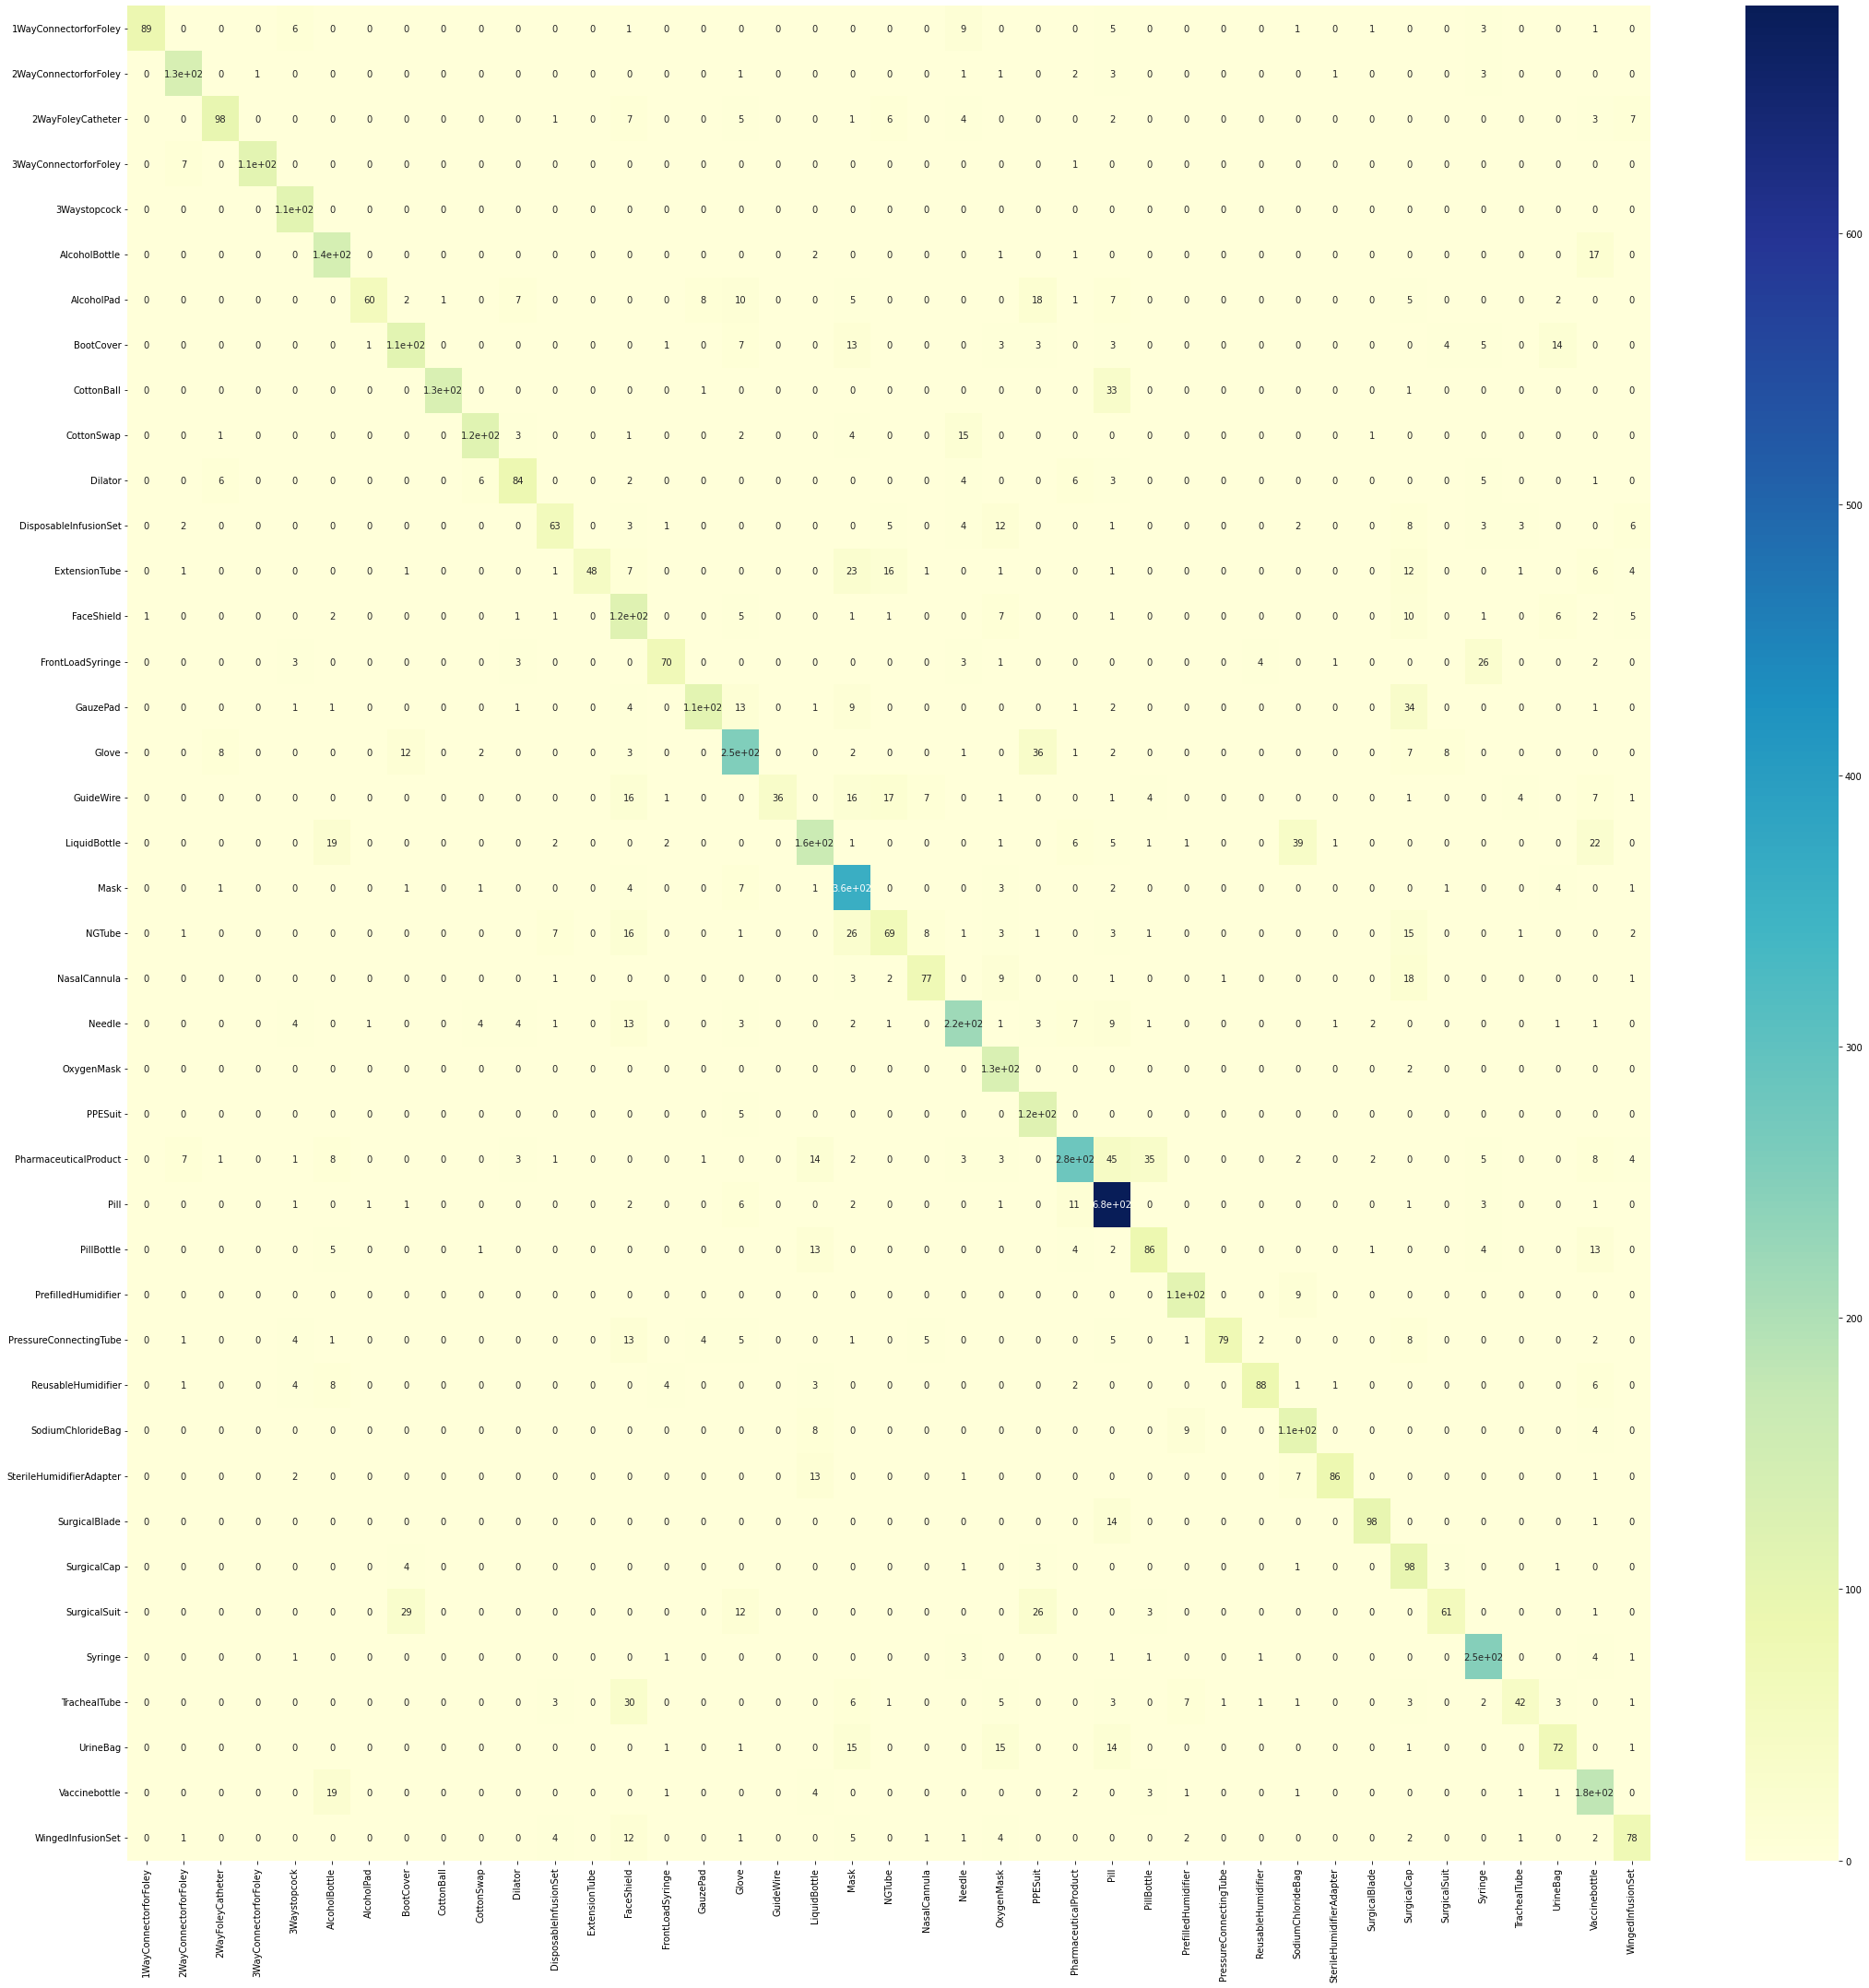

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

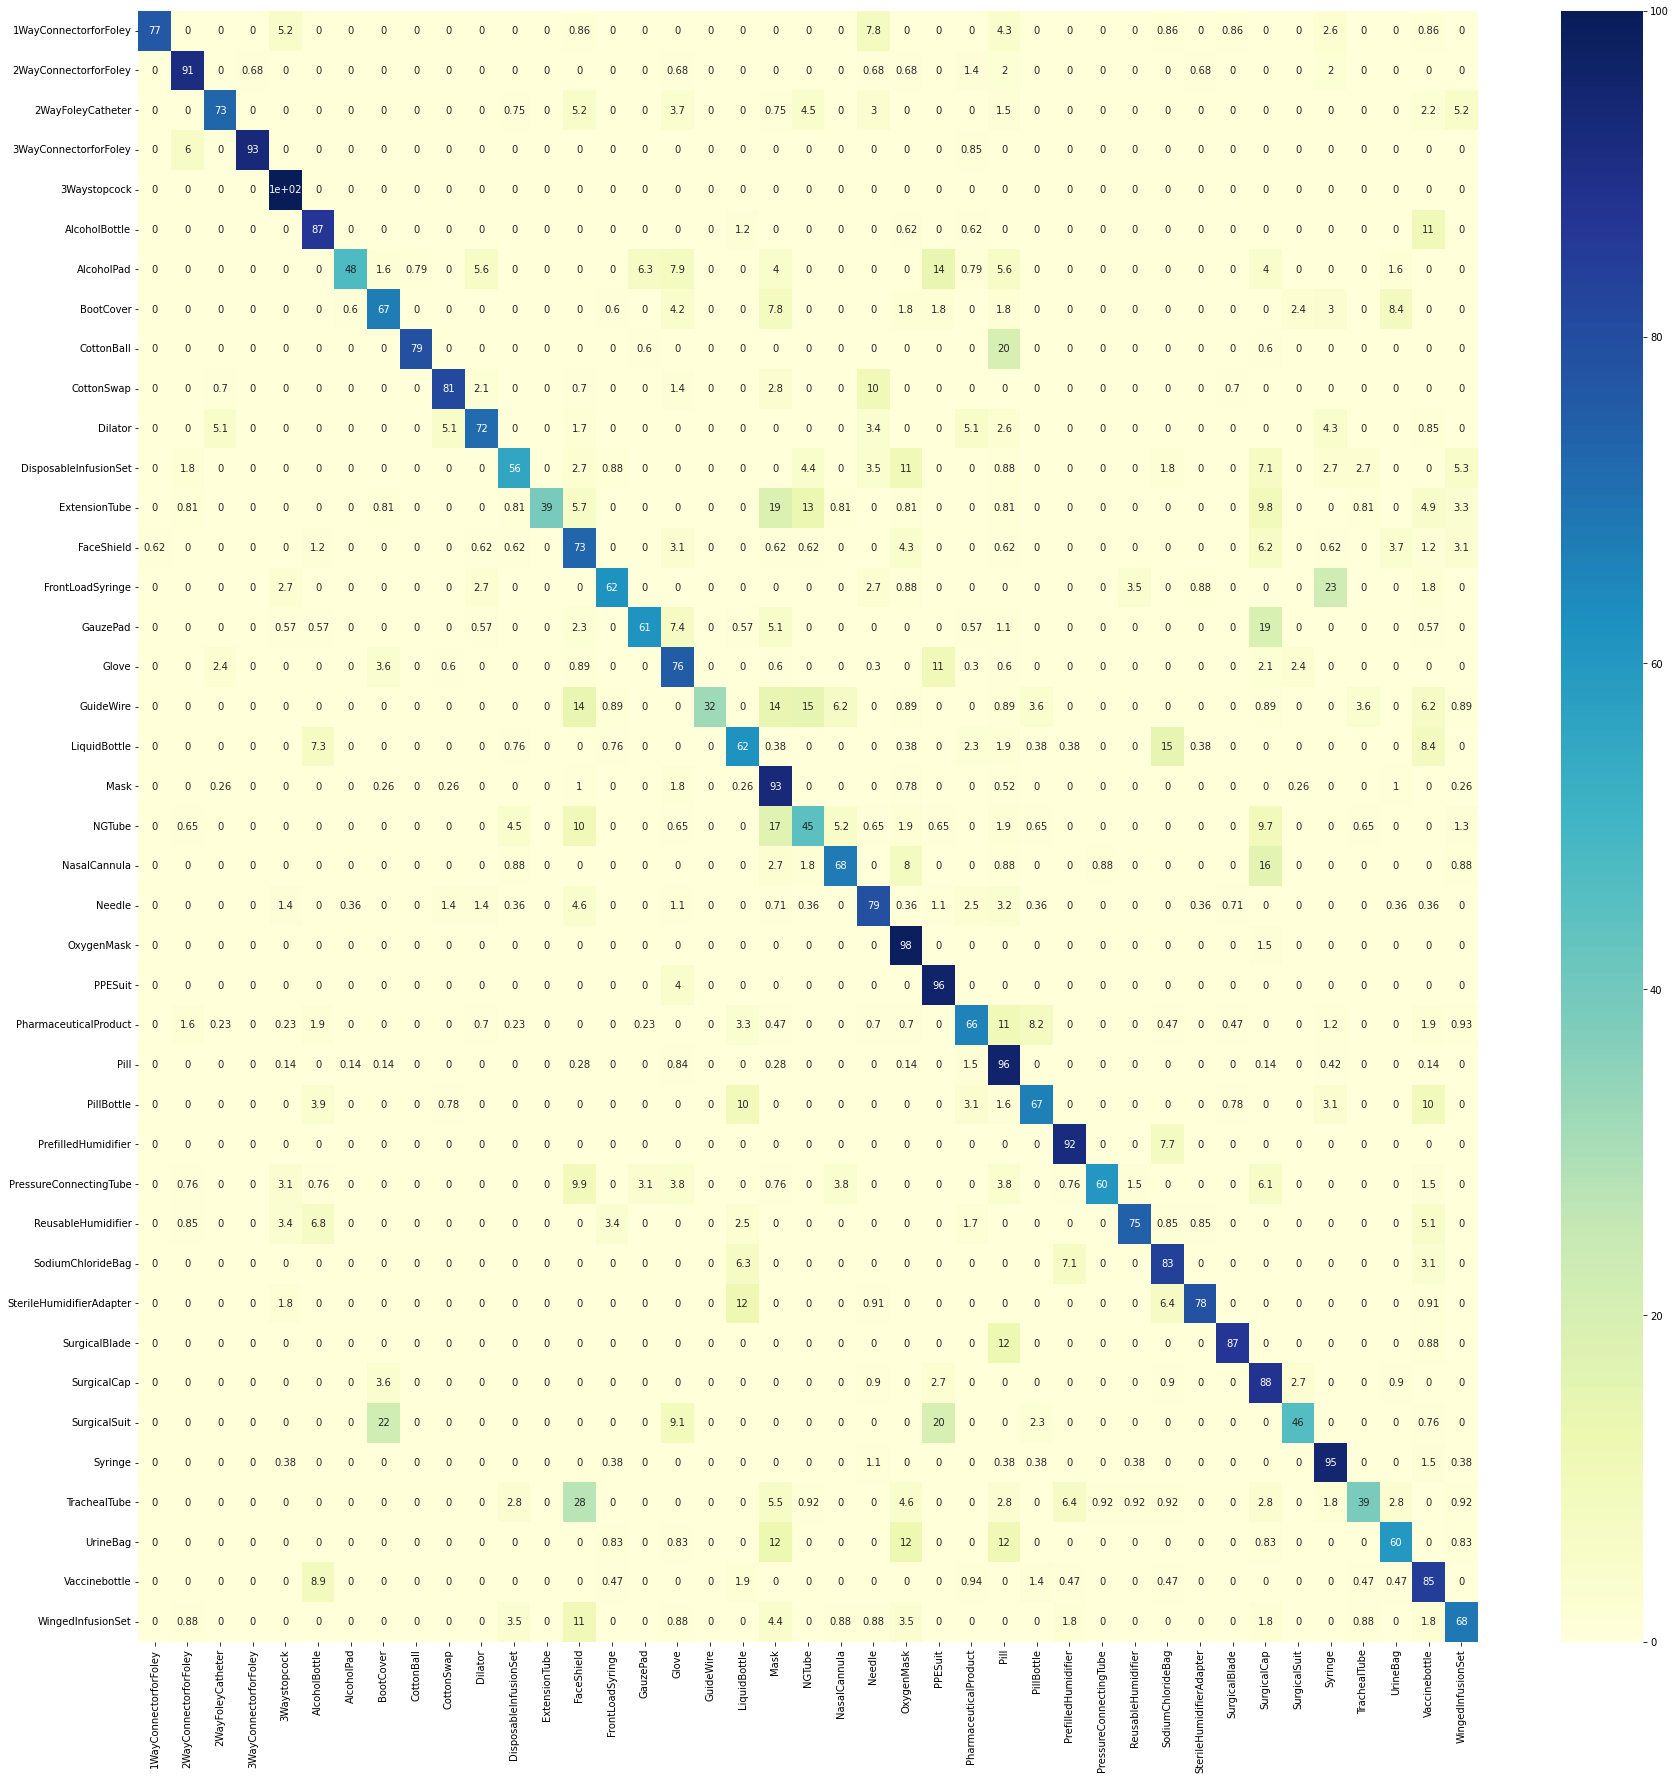

In [10]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")